In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import time
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio


root = "/hdd_mnt/onurcan/onurk/datasets/"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 24
# stage = "train"
# dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
# stage = "val"
# val_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
# stage = "test"
# test_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)

In [ ]:
# selected_indices_dataloader = list(range(300)) + [random.randrange(len(dataloader.dataset)) for _ in range(300)]
# dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataloader.dataset, selected_indices_dataloader), batch_size=batch_size)
# len(dataloader)

In [3]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2End(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.11, -1.9, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0

    def forward(self, hio_output, amplitude, support, total_time_steps = None, last_iterations_to_train = 1):
        total_time_steps = total_time_steps or self.total_iterations

        assert total_time_steps <= self.total_iterations, "total_time_steps should be smaller than total_iterations"
        assert last_iterations_to_train <= total_time_steps, "last_iterations_to_train should be smaller than total_time_steps"
            
        x_ = hio_output # B, 10, W, H
        
        self.denoiser.eval()
        with torch.no_grad():
            for i in range(total_time_steps - last_iterations_to_train):
                z_ = self.denoiser(x_ / 255.0, i) * 255.0 # B, 5, W, H
                z_ = torch.clamp(z_, min=0.0, max=255.0)
                
                x_ = self.dc(z_, amplitude, i, support)
                
                if (i == total_time_steps - 1) and (last_iterations_to_train == 0):
                    return [z_]
                
                x_ = torch.cat([x_, z_], dim=1)
                
                x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        self.denoiser.train()
        output_list = []
        for i in range(total_time_steps - last_iterations_to_train, total_time_steps):
            z_ = self.denoiser(x_ / 255.0, i) * 255.0
            z_ = torch.clamp(z_, min=0.0, max=255.0)
            
            output_list.append(z_) # normalize(x_)
            
            x_ = self.dc(z_, amplitude, i, support)
            
            output_list.append(x_) # normalize(x_)
            
            x_ = torch.cat([x_, z_], dim=1) # before z_ x_
            
            x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        return output_list

    def dc(self, z, b, i, support):
        z_k = zero_padding_twice(z)
        z_0 = z_k
        
        y_new = self.lam[i] * b + (1 - self.lam[i]) * fft2d(z_0).abs()

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            # x_kprime = self.lam[i] * ifft2d(torch.polar(b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            x_kprime = ifft2d(torch.polar(y_new, Fz.angle())).real
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [4]:
total_iterations = 18
denoiser_architecture = "UNet2DMulti"

end2end_model = End2End(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(end2end_model.parameters(), lr=5e-5, betas=(0.95, 0.999), weight_decay=1e-5)

In [5]:
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__largenew_betterdc.pth"))

<All keys matched successfully>

In [6]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle

#filename = "notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___testtttyesyesyes_103_allimages_finalll___newwithcorrectsnr2_____largenew_"

In [13]:
stage = "val"
test_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size=1, alpha=3)

In [14]:
save_paths = [str(path).replace("/val/", "/val_outputs_large_alpha_3/") for path in test_dataloader.dataset.gt_image_paths]

In [17]:
end2end_model.eval()
with torch.no_grad():
    for index_dataloader, (im, am, am_noiseless, sp, robust_output) in tqdm(enumerate(test_dataloader)):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        # robust_output = robust_output.to(device).float()
        
        top_k = 10
        g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
        end_time = time.time()

        im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
        g_cropped_normalized = crop_center_half(g)
        
        im_cropped_normalized_repeated = repeat(
            im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
        )

        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
        robust_output = all_mse_loss_corrected[0] # * 255
        robust_output = robust_output.to(device).float()
        robust_output = torch.clip(robust_output, 0, 255)        

        

        outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
        output = outputs[-1]
        # output = outputs[-1][:, 0:1, :, :]
        
        # save as npy
        output = output.squeeze().cpu().numpy()
        np.save(save_paths[index_dataloader], output)
        
        # break
        
        # target_im = crop_center_half(im).float()
        # robust_output = robust_output[:, 0:1, :, :]


300it [07:49,  1.57s/it]


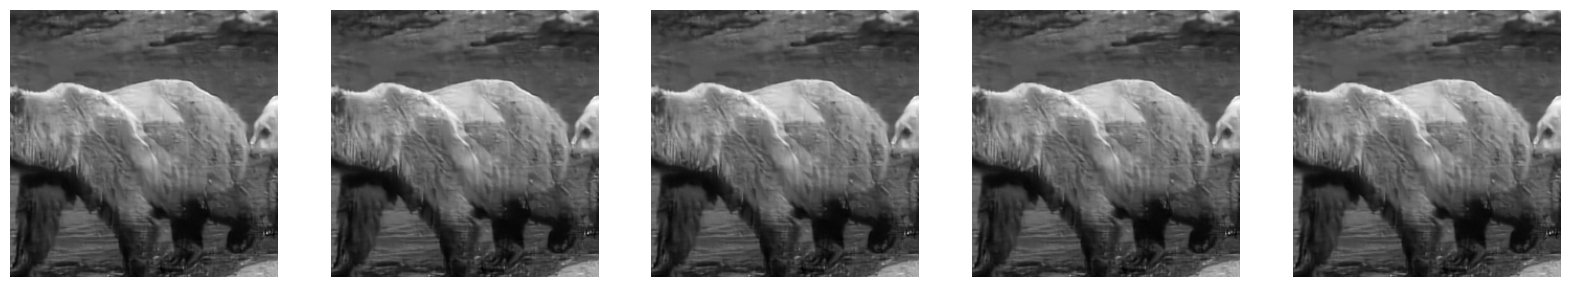

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# numpy read '/hdd_mnt/onurcan/onurk/datasets/train_outputs_large_alpha_3/0.png.npy'

try_ = np.load('/hdd_mnt/onurcan/onurk/datasets/train_outputs_large_alpha_3/0.png.npy')
# it is a 5x256x256 numpy array
# visualize with 5 subplots
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(try_[i], cmap='gray')
    plt.axis('off')

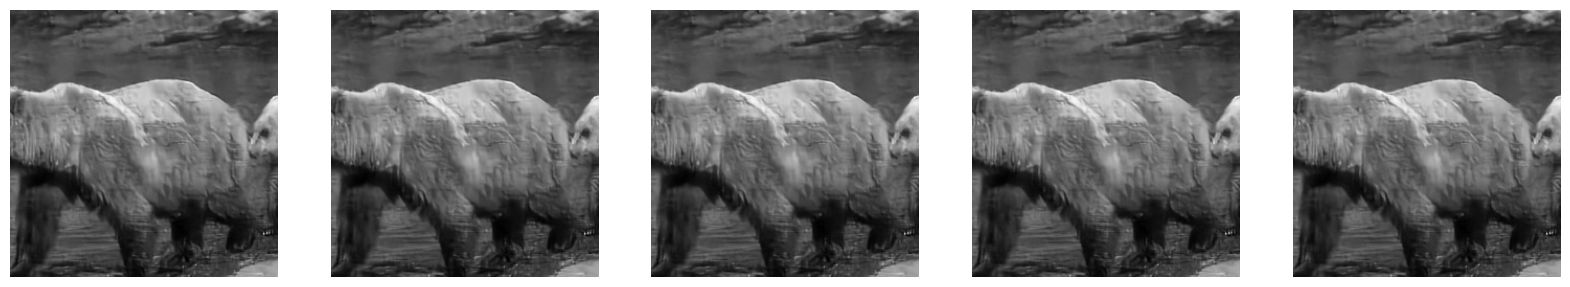

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# numpy read '/hdd_mnt/onurcan/onurk/datasets/train_outputs_large_alpha_3/0.png.npy'

try_ = np.load('/hdd_mnt/onurcan/onurk/datasets/train_outputs_large_alpha_3/0.png.npy')
# it is a 5x256x256 numpy array
# visualize with 5 subplots
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(try_[i], cmap='gray')
    plt.axis('off')